<a href="https://colab.research.google.com/github/naemililia/masterthesis/blob/main/finetune_and_eval_eurosat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will be used to finetune models on the eurosat finetune dataset

## Step 0: installs and imports

In [ ]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 16.0 MB/s eta 0:00:00


In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
# create a folder for model checkpoints

%cd /home
!sudo mkdir checkpoints

/home


In [ ]:
# connect drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import rasterio
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import csv
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
#import segmentation_models_pytorch as smp
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms.functional as F
from skimage import io
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## Create DataLoaders for the finetune data



In [ ]:
def iloader(path):
    image = np.asarray((io.imread(path))/5000,dtype='float32') # 5000 because of histogram
    return image.transpose(2,0,1)

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split

def load_training_data():
    root = '/content/drive/MyDrive/baseline_dataset/' # baseline_dataset (ist damit auch gleichzeitig das finetune dataset)
    loader_function = iloader  # Make sure iloader is defined correctly

    # Load the dataset
    dataset = torchvision.datasets.DatasetFolder(root=root, loader=iloader, transform=None, extensions='tif')

    # Get indices for all data points and their corresponding targets
    indices = list(range(len(dataset)))
    targets = [dataset.samples[i][1] for i in indices]

    # First split: train and temporary (which will be further split into validation and test)
    train_indices, temp_indices = train_test_split(indices, test_size=0.3, stratify=targets, random_state=42)

    # Targets for the temp set
    temp_targets = [targets[i] for i in temp_indices]

    # Second split: temp into validation and test
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, stratify=temp_targets, random_state=42)

    # Create Subset instances
    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, val_indices)
    test_set = Subset(dataset, test_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_set, batch_size=16, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_set, batch_size=16, shuffle=False, drop_last=True)

    return dataset, train_loader, val_loader, test_loader

# Now you can call load_data to get your data loaders with properly stratified splits.
#train_loader, val_loader, test_loader = load_data()

In [ ]:
dataset_all, train_loader, val_loader, test_loader = load_training_data()

In [ ]:
dataset_all.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [ ]:
# augmentation functions:

def sigmoid(z):
    return 1/(1+np.exp(-z))

def cus_aug(data):
    data = torch.rot90(data,random.randint(-3,3), dims=random.choice([[3,2],[2,3]]))
    if random.random()>0.5:
        data = torch.flip(data, dims = random.choice([[2,],[3,],[2,3]]))
    #pixmis = torch.empty_like(data).random_(data.shape[-1])
    #pixmis = torch.where(pixmis>(data.shape[-1]/8),torch.ones_like(data),torch.zeros_like(data))
    return data#* pixmis

def Load_model():
    model_ft = models.resnet18()#pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 10)
    inBands = 13
    model_ft.conv1 = nn.Conv2d(inBands, 64, kernel_size=7, stride=2, padding = 3, bias = False)
    print('Model Loaded')
    return model_ft

def Load_raw_encoder_for_finetune():
    model_ft = models.resnet18()#pretrained=True)
    num_ftrs = model_ft.fc.in_features
    #model_ft.fc = nn.Linear(num_ftrs, 10)
    inBands = 13
    model_ft.conv1 = nn.Conv2d(inBands, 64, kernel_size=7, stride=2, padding = 3, bias = False)
    print('Model Loaded')
    return model_ft

def accuracy(gt_S,pred_S):
    _, alp = torch.max(torch.from_numpy(pred_S), 1)
    return accuracy_score(gt_S,np.asarray(alp))#np.mean(F1score)

def F1_score(gt_S, pred_S):
  _, pred = torch.max(torch.from_numpy(pred_S),1)
  f1 = f1_score(gt_S, np.asarray(pred), average='macro')
  return f1

In [ ]:
def validation(model, val_,):
    model.eval()
    #tot_acc=[]
    test_iter=0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_):
            print(batch_idx)
            data, target = cus_aug(Variable(data.cuda())), Variable(target.cuda())
            output = model(data)
            _, pred = torch.max(output, 1)
            pred = output.data.cpu().numpy()
            gt = target.data.cpu().numpy()
            if test_iter==0:
                all_pred=pred
                all_gt=gt
            else:
                all_pred=np.vstack((all_pred,pred))
                all_gt  =np.vstack((all_gt,gt))

            test_iter=test_iter+1
       # acc=accuracy(all_gt.reshape(all_gt.shape[0] * all_gt.shape[1]),all_pred)
       # f1 = F1_score(all_gt.reshape(all_gt.shape[0] * all_gt.shape[1]),all_pred)
        model.train()
        return acc, f1#,cm

## Define the model setup (pretext task)

for the pretext, this first needs to be of the same architecture like the model that I have trained my pretext task on.

In order to get this right, I need to determine which labels were used in the pretext model, and I will do this via a global variable

In [ ]:
LABELS_USED_IN_PRETEXT = ['LC'] # ['BUILT', 'LC'] / ['BUILT'] / ['POP'] / ['LC'] / ['BUILT', 'LC', 'POP']

In [ ]:
# initiate the model that the weights will be transferred into
net = Load_raw_encoder_for_finetune()

Model Loaded


In [ ]:
# just to look at the structure of the mdel
state_dict_net = net.state_dict()
state_dict_net.keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

In [ ]:
# step 1: initialise the model with the same architecture as the pretrained one:

if LABELS_USED_IN_PRETEXT == ['BUILT']:
  net = smp.Unet(encoder_name="resnet18", encoder_weights=None, in_channels = 13, classes= 6) # if we only use LC or POP

elif LABELS_USED_IN_PRETEXT == ['LC']:
  net = smp.Unet(encoder_name="resnet18", encoder_weights=None, in_channels = 13, classes= 18)

# i never converted BN to GN for eurosat

In [ ]:
# this is to retrieve
model_save_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/pretext/'
checkpoints = os.listdir(model_save_path)
state_dict_PT = torch.load(model_save_path + 'pretext_eurosat_allData_lr001LC_40_0.7260022206156778.cp') # load the model i want to finetune

state_dict_PT.keys()
#state_dict_PT['segmentation_head.0.weight'].shape

odict_keys(['encoder.conv1.weight', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.bn1.num_batches_tracked', 'encoder.layer1.0.conv1.weight', 'encoder.layer1.0.bn1.weight', 'encoder.layer1.0.bn1.bias', 'encoder.layer1.0.bn1.running_mean', 'encoder.layer1.0.bn1.running_var', 'encoder.layer1.0.bn1.num_batches_tracked', 'encoder.layer1.0.conv2.weight', 'encoder.layer1.0.bn2.weight', 'encoder.layer1.0.bn2.bias', 'encoder.layer1.0.bn2.running_mean', 'encoder.layer1.0.bn2.running_var', 'encoder.layer1.0.bn2.num_batches_tracked', 'encoder.layer1.1.conv1.weight', 'encoder.layer1.1.bn1.weight', 'encoder.layer1.1.bn1.bias', 'encoder.layer1.1.bn1.running_mean', 'encoder.layer1.1.bn1.running_var', 'encoder.layer1.1.bn1.num_batches_tracked', 'encoder.layer1.1.conv2.weight', 'encoder.layer1.1.bn2.weight', 'encoder.layer1.1.bn2.bias', 'encoder.layer1.1.bn2.running_mean', 'encoder.layer1.1.bn2.running_var', 'encoder.layer1.1.bn2.num_batches_tr

In [ ]:
encoder_state_dict_test = {k.replace('encoder.', ''): v for k, v in state_dict_PT.items() if k.startswith('encoder.')}
encoder_state_dict_test.keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'l

In [ ]:
# load the state dict that was saved into there
net.load_state_dict(encoder_state_dict_test, strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [ ]:
# step 4: adjust the last layer to now only have 10 outputs instead of 18 / 6:
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)


In [ ]:
# step 3: freeze the encoder TODO: MAKE SURE THAT ITS ONLY TEH ENCODER; NT THE FULLY CONNECTED LAYER THAT WONT CHANGE
for param in net.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the fully connected layer
for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
import torch.optim as optim

lr = 0.001 # like in the baseline
milestones = [50,75,90] # multistep scheduler


# step 5: define the optimizer, scheduler, and loss function
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
criterion = nn.CrossEntropyLoss() # like in baselie

#TODO: but this can be copied straight from train i think

## Contrastive learning model definition


model name (one where val_loss is lowest):
- CL_allData_BUILT_256_0001_74_64.27335119247437.cp
- CL_allData_BUILT_128_59_116.12763404846191.cp

In [ ]:
# create a model that will get the transferred encoder weights, in this case a resnet18
# this is the correct structure immediately

net = Load_raw_encoder_for_finetune()

Model Loaded


In [ ]:
# this is to retrieve the state_dict from the pretrained model
model_save_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/contrastive_learning/'
checkpoints = os.listdir(model_save_path)
state_dict = torch.load(model_save_path + 'CL_allData_LC_0001_eurosat_256_39_130.7717924118042.cp')

state_dict.keys()

odict_keys(['encoder_im1.conv1.weight', 'encoder_im1.bn1.weight', 'encoder_im1.bn1.bias', 'encoder_im1.bn1.running_mean', 'encoder_im1.bn1.running_var', 'encoder_im1.bn1.num_batches_tracked', 'encoder_im1.layer1.0.conv1.weight', 'encoder_im1.layer1.0.bn1.weight', 'encoder_im1.layer1.0.bn1.bias', 'encoder_im1.layer1.0.bn1.running_mean', 'encoder_im1.layer1.0.bn1.running_var', 'encoder_im1.layer1.0.bn1.num_batches_tracked', 'encoder_im1.layer1.0.conv2.weight', 'encoder_im1.layer1.0.bn2.weight', 'encoder_im1.layer1.0.bn2.bias', 'encoder_im1.layer1.0.bn2.running_mean', 'encoder_im1.layer1.0.bn2.running_var', 'encoder_im1.layer1.0.bn2.num_batches_tracked', 'encoder_im1.layer1.1.conv1.weight', 'encoder_im1.layer1.1.bn1.weight', 'encoder_im1.layer1.1.bn1.bias', 'encoder_im1.layer1.1.bn1.running_mean', 'encoder_im1.layer1.1.bn1.running_var', 'encoder_im1.layer1.1.bn1.num_batches_tracked', 'encoder_im1.layer1.1.conv2.weight', 'encoder_im1.layer1.1.bn2.weight', 'encoder_im1.layer1.1.bn2.bias', '

In [ ]:
# get only the encoder_im1 keys:
encoder_im1_state_dict = {k.replace('encoder_im1.', ''): v for k, v in state_dict.items() if k.startswith('encoder_im1.')}
encoder_im1_state_dict.keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'l

In [ ]:
# transfer only the encoder weigts:

net.load_state_dict(encoder_im1_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [ ]:
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 10)

In [ ]:
# step 3: freeze the encoder (as I only want to keep the weights of that one, and adapt the decoder)
for param in net.parameters():
    param.requires_grad = False

# Unfreeze the parameters of the fully connected layer
for param in net.fc.parameters():
    param.requires_grad = True

In [ ]:
import torch.optim as optim

lr = 0.001 # like in the baseline
milestones = [50,75,90] # multistep scheduler


# step 5: define the optimizer, scheduler, and loss function
optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
criterion = nn.CrossEntropyLoss() # like in baselie

## Define the training & validation schemes

TODO: this can probably also be copied straight from the Train.ipynb from teh authors as i am l

In [ ]:
import time
from IPython.display import clear_output

def train(net, train_, val_, criterion, optimizer, epochs=None, scheduler=None, weights=None, save_epoch = 10):
    # losses=[]; acc=[]; mean_losses=[]; val_acc=[]
    # iter_ = t0 =0
    # for e in tqdm(range(1, epochs + 1)):
    #     net.train()
    #     for batch_idx, (data, target) in enumerate(tqdm(train_)):
    #         data, target =  cus_aug(data.cuda()), target.cuda()
    #         optimizer.zero_grad()
    #         output = net(data)
    #         loss = criterion(output, target)
    #         loss.backward()
    #         optimizer.step()
    #         losses.append(loss.item())
    #         mean_losses.append(np.mean(losses[max(0,iter_-100):iter_]))
    #         if iter_ % 2 == 0: #printing after 2 epochs
    #             #clear_output()
    #             print('Iteration Number',iter_,'{} seconds'.format(time.time() - t0))
    #             t0 = time.time()
    #             pred = output.data.cpu().numpy()#[0]
    #             pred=sigmoid(pred)
    #             gt = target.data.cpu().numpy()#[0]
    #             acc.append(accuracy(gt,pred))
    #             print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\tLearning Rate:{}'.format(
    #                 e, epochs, batch_idx, len(train_),
    #                 100. * batch_idx / len(train_), loss.item(), acc[-1],optimizer.param_groups[0]['lr']))
    #             plt.plot(mean_losses) and plt.show()
    #             val_acc.append(validation(net, val_))
    #             print('validation accuracy : {}'.format(val_acc[-1]))
    #             plt.plot( range(len(acc)) ,acc,'b',label = 'training')
    #             plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
    #             plt.legend() and plt.show()
    #             #print(mylabels[np.where(gt[1,:])[0]])
    #         iter_ += 1

    #         del(data, target, loss)
    #     if scheduler is not None:
    #        scheduler.step()
    #     if e % save_epoch == 0:
    #         save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_eurosat/'
    #         #save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
    #         save_path = save_base_path + '{}_{}.cp'.format(RUNNAME, e)
    #         torch.save(net.state_dict(), save_path)

    losses, acc, f1s , mean_losses, val_acc, val_f1 = [], [], [], [], [], []
    iter_, t0 = 0, time.time()

    for e in tqdm(range(1, epochs + 1), desc="Epochs"):
        net.train()
        for batch_idx, (data, target) in enumerate(tqdm(train_, desc="Training", leave=False)):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            mean_losses.append(np.mean(losses[max(0, iter_ - 100):]))

            if iter_ % 10 == 0:
                print(f'Iteration Number {iter_}, Time elapsed: {time.time() - t0:.2f} seconds')
                t0 = time.time()
                pred = sigmoid(output.data.cpu().numpy())
                gt = target.data.cpu().numpy()
               # print(gt, pred)
               # acc.append(accuracy(gt, pred))
                #f1s.append(F1_score(gt,pred))
               # print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\tF1: {}\tLearning Rate:{}'.format(
                  #  e, epochs, batch_idx, len(train_),
                   # 100. * batch_idx / len(train_), loss.item(), acc[-1], f1s[-1],optimizer.param_groups[0]['lr']))
                #plt.plot(mean_losses) and plt.show()
                # val_acc.append(validation(net, val_))
                # print('validation accuracy : {}'.format(val_acc[-1]))
                # plt.plot( range(len(acc)) ,acc,'b',label = 'training')
                # plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
                #plt.legend() and plt.show()
                #plt.show()

            if iter_ % 395 == 0 and iter_ != 0:
                clear_output()
                plt.plot(mean_losses) and plt.show()
            #    val_accuracy, val_f1score = validation(net, val_)
               # val_acc.append(val_accuracy)
               # val_f1.append(val_f1score)
               # print('validation accuracy : {}'.format(val_acc[-1]))
               # print('validation F1 : {}'.format(val_f1[-1]))
                #plt.plot( range(len(acc)) ,acc,'b',label = 'training')
                #plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
                #plt.legend() and plt.show()
                #plt.show()
                save_base_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/finetune/'
                #save_path = os.path.join("checkpoints", "{}_{}_{}.cp".format(RUNNAME, i, iou.item()))
                save_path = save_base_path + '{}_{}.cp'.format(RUNNAME, iter_)
                torch.save(net.state_dict(), save_path)

            iter_ += 1

        if scheduler is not None:
            scheduler.step()

        # if e % save_epoch == 0:
        #     save_path = f'/path/to/save/models/epoch_{e}.pth'
        #     torch.save(net.state_dict(), save_path)
    return net, val_accuracy, val_f1, acc, f1s

## Train the model

In [ ]:
LABELS_USED_IN_PRETEXT = ['LC']

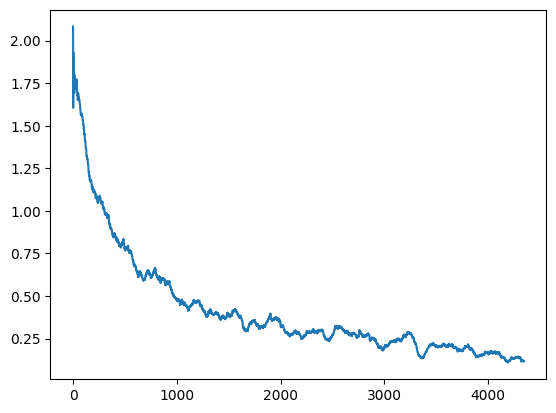

Iteration Number 4350, Time elapsed: 1.32 seconds
Iteration Number 4360, Time elapsed: 0.97 seconds
Iteration Number 4370, Time elapsed: 0.94 seconds


KeyboardInterrupt: 

In [ ]:
from tqdm.notebook import tqdm

RUNNAME = f'finetune_LR0.001_all_eurosat_LC_CL_39th_UNFREEZED_{LABELS_USED_IN_PRETEXT[0]}'

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

net = net.cuda()
net, val_acc, val_f1, acc, f1s = train(net, train_loader, val_loader, criterion, optimizer, 1000, scheduler)

In [ ]:
import json
with open(f'/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/finetune/{RUNNAME}.json', 'w') as f:
        json.dump({'val_acc': val_acc,
                  'val_f1': val_f1,
                  'acc': acc,
                  'f1s': f1s}, f)

NameError: name 'val_acc' is not defined

## Evaluate




In [ ]:
# load the model from teh epoch you want to evaluate:

net = Load_model()


# this is to retrieve
model_save_path = '/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/baseline_eurosat/'
checkpoints = os.listdir(model_save_path)
state_dict = torch.load(model_save_path + 'baseline_LR0.001_honest_final_second_try_eurosat_5135.cp') # finetune_BUILT_CL_256_74_withGN_with_all_data_50_0.5673146843910217 / finetune_BUILT_CL_256_74_withBN_with_all_data_50_0.5567578673362732


net.load_state_dict(state_dict)

Model Loaded


<All keys matched successfully>

In [ ]:
def get_ypred_ytrue(net, test_):
  net.eval()
  y_true = []
  y_pred = []

  with torch.no_grad():
    for inputs, labels in test_:
      inputs, labels = inputs.cuda(), labels.cuda()
      outputs = net(inputs)
      _, predicted = torch.max(outputs,1)
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

  return y_pred, y_true

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score


y_pred, y_true = get_ypred_ytrue(net, test_loader)

def evaluate_eurosat_model(y_pred, y_true):
  cm = confusion_matrix(y_true, y_pred)
  print('confusion matrix:')
  print(cm)


#   {'AnnualCrop': 0,
#  'Forest': 1,
#  'HerbaceousVegetation': 2,
#  'Highway': 3,
#  'Industrial': 4,
#  'Pasture': 5,
#  'PermanentCrop': 6,
#  'Residential': 7,
#  'River': 8,
#  'SeaLake': 9}

  #class_names = ['AnnualCrop', 'Forest', 'Industrial', 'PermanentCrop', 'Highway', 'Pasture', 'River', 'HerbaceousVegetation', 'Forest', 'SeaLake']
  print('classification report:')
  report = classification_report(y_true, y_pred)
  print(report)

  accuracy = accuracy_score(y_true, y_pred)
  print('accuracy overall:')
  print(accuracy)

  precision = precision_score(y_true, y_pred, average='macro')
  print('precision macro average:')
  print(precision)

  recall = recall_score(y_true, y_pred, average='macro')
  print('recall macro average:')
  print(recall)

  f1_macro = 2*((precision * recall) / (1/precision) + (1/recall))
  print('F1-macro:')
  print(f1_macro)

  return cm, report, accuracy, precision, recall, f1_macro




In [ ]:
RUNNAME = 'evaluate_last_finetuned_model_LC_CL_eurosat_UNFREEZED'

In [ ]:
from tqdm import tqdm_notebook as tqdm
import json

def test_loop(test_data_loader, net):
  net = net.eval()
  net = net.cuda()
  count = 0
  y_true = []
  y_pred = []
  with torch.no_grad():
      for (images, labels) in tqdm(test_data_loader):
          net = net.cuda()
          outputs = net(images.cuda())
          _, predicted = torch.max(outputs,1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

  cm, report, accuracy, precision, recall, f1_macro = evaluate_eurosat_model(y_pred,y_true)

  # with open(f'/content/drive/MyDrive/Uni/TUB/Semester/5 - Masterarbeit/models/finetune/{RUNNAME}_evaluation.json', 'w') as f:
  #   json.dump({'cm': cm.item(),
  #              #'report': report,
  #              'accuracy': accuracy,
  #              'precision': precision.item(),
  #              'recall': recall.item()},f)
  #              #'f1_macro': f1_macro},f)

  return y_true, y_pred, cm, report, accuracy, precision, recall, f1_macro

In [ ]:
y_true, y_pred, cm, report, accuracy, precision, recall, f1_macro = test_loop(test_loader, net)

  0%|          | 0/84 [00:00<?, ?it/s]

confusion matrix:
[[142   0   4   0   0   2   2   0   0   0]
 [  0 146   4   0   0   0   0   0   0   0]
 [  0   2 137   1   0   1   5   1   0   0]
 [  0   0   1 111   6   0   1   0   5   0]
 [  0   0   0   1 122   0   0   0   1   0]
 [  2   8   7   2   1  71  10   0   0   0]
 [  9   0   1   2   0   0 110   3   0   0]
 [  0   0   0   1   3   0   2 144   0   0]
 [  0   0   0   2   0   1   0   0 121   0]
 [  0   0   0   0   0   0   0   0   3 146]]
classification report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       150
           1       0.94      0.97      0.95       150
           2       0.89      0.93      0.91       147
           3       0.93      0.90      0.91       124
           4       0.92      0.98      0.95       124
           5       0.95      0.70      0.81       101
           6       0.85      0.88      0.86       125
           7       0.97      0.96      0.97       150
           8       0.93      0.98      0.